# Отчет по лабораторной № 6, lite версия

В рамках данной лабораторной работы было предложено сравнить различные способы выполнения множества процессов, которые либо выполняют тяжелые по вычислениям задания, либо много читают/пишут в файлы.

## Характеристики машины

Из-за технических трудностей не получилось воспользоваться виртуальной машиной, так что все вычисления производились на арендованом VPS со следующими характеристиками:

- 2 x 3,6 ГГц CPU (на время выполнения задач на 1 ядро второе было вручную выключено)
- 4 Гб RAM
- 60 Гб NVMe (3000-7500 MB/s)

Второе ядро отключалось путем изменения флага `online` (`sudo echo 0 > / sys/devices/system/cpu/cpu1/online`)

## Алгоритмы для бенчмарка 

### CPU
Для создания нагрузки на CPU в течение 2-3 секунд была создана программа на `bash`, считающая произвольную последовательность:
```console
    cpu_intensive_task() {
        local n=$1
        local iterations=200000 
        local result=0

        for ((i = 0; i < iterations; i++)); do
            result=$((result + (n * n) - (n / 2) + (n % 3) - (n ** 3)))
            result=$((result ^ i)) 
        done

        echo $result
    }
```

Такой алгоритм выполняется примерно `0m3.561s`

### Memory
Для нагрузки на чтение/запись были сгенерированы 20 файлов со случайными натуральными числами, каждый из которых имеет размер в 22МБ. Сам алгоритм - скрипт проходится по файлу, умножая каждое число на 2 и записывая результат в отдельный временный файл. 

Такой алгоритм выполняется примерно `0m2.331s` 

## План эксперимента
Не изменился относительно ТЗ, будем запускать от 1 до 20 программ и таймировать, за сколько они все выполнятся. Будем пробовать делать это на 1 ядре, на 2 ядрах, последовательно и параллельно. И каждый этап будем выполнять по 10 раз чтобы минимизировать влияние случайных фоновых процессов на результаты



## Парсинг результатов и построение графиков

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
%matplotlib inline

In [2]:
def process_file(filename: str) -> list:
    with open(filename, 'r') as file:
        data = file.read()
    output = []
    for line in data.split('\n'):
        splitted = line.split()
        if len(splitted) < 2:
            continue
        processes_amt, exec_time = splitted
        exec_time_m, exec_time_s = exec_time.split('m')
        exec_time_s = exec_time_s.rstrip('s')
        exec_time_s = float(exec_time_s) + float(exec_time_m) * 60 
        output.append([int(processes_amt), exec_time_s])
    return output

In [3]:
def get_mean(array: list) -> list:
    cur_processes = 1
    cur_sum = 0
    cur_amt = 0
    output = []
    for i in range(len(array)):
        if array[i][0] != cur_processes:
            if cur_amt != 0:
                output.append([cur_processes, cur_sum / cur_amt])
            cur_amt = 0
            cur_processes = array[i][0]
            cur_sum = 0
        cur_sum += array[i][1]
        cur_amt += 1
    output.append([cur_processes, cur_sum / cur_amt])
    return output

## CPU:

In [4]:
mono_parallel = get_mean(process_file('data/parallel-mono.log'))
mono_sequential = get_mean(process_file('data/sequential-mono.log'))

In [5]:
duo_parallel = get_mean(process_file('data/parallel-duo.log'))
duo_sequential = get_mean(process_file('data/sequential-duo.log'))

In [6]:
datasets = [
    ('1 CPU, parallel', mono_parallel),
    ('1 CPU, sequential', mono_sequential),
    ('2 CPU, parallel', duo_parallel),
    ('2 CPU, sequential', duo_sequential),
]

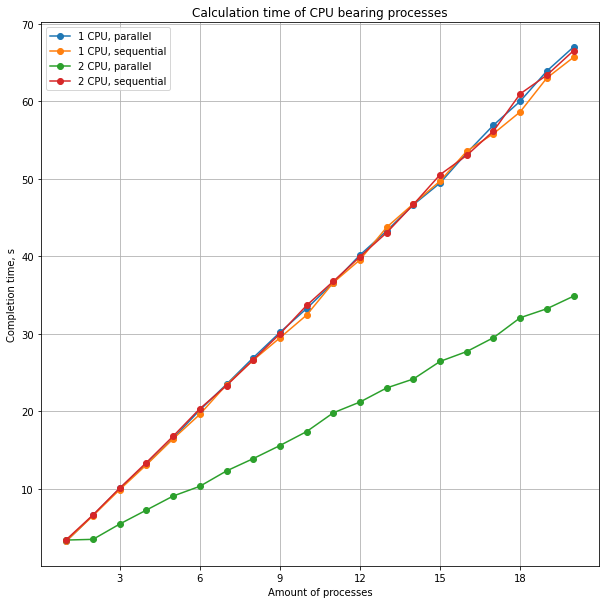

In [7]:
plt.figure(figsize=(10, 10))

for name, data in datasets:
    x_values = [pair[0] for pair in data]
    y_values = [pair[1] for pair in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', label=name)

plt.title('Calculation time of CPU bearing processes')
plt.xlabel('Amount of processes')
plt.ylabel('Completion time, s')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend()

plt.grid(True)
plt.show()

## Memory

In [8]:
mono_parallel = get_mean(process_file('mem/data/parallel-mono.log'))
mono_sequential = get_mean(process_file('mem/data/sequential-mono.log'))
duo_parallel = get_mean(process_file('mem/data/parallel-duo.log'))
duo_sequential = get_mean(process_file('mem/data/sequential-duo.log'))

In [9]:
datasets = [
    ('1 CPU, parallel', mono_parallel),
    ('1 CPU, sequential', mono_sequential),
    ('2 CPU, parallel', duo_parallel),
    ('2 CPU, sequential', duo_sequential),
]

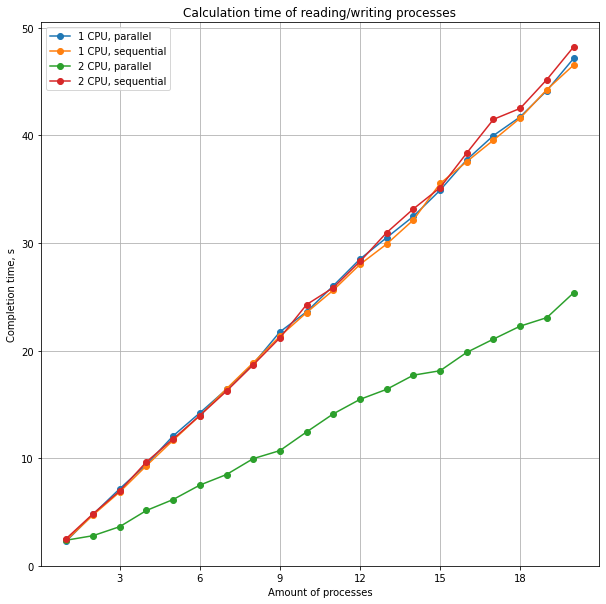

In [10]:
plt.figure(figsize=(10, 10))

for name, data in datasets:
    x_values = [pair[0] for pair in data]
    y_values = [pair[1] for pair in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', label=name)

plt.title('Calculation time of reading/writing processes')
plt.xlabel('Amount of processes')
plt.ylabel('Completion time, s')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend()

plt.grid(True)
plt.show()

## Инсайты

Как можно заметить, все графики кроме графика параллельных вычислений на 2 ядрах одинаковы в пределах погрешности.
Для последовательного выполнения очевидно сходство графиков, всегда время выполения будет равно $N \cdot t$, где $N$ - количество процессов, $t$ - среднее время выполнения одного. А в случае с параллельным запуском на 1 ядре такой результат объясняется тем, что просто некуда параллелить. Есть одно ядро, за единицу времени оно может использоваться одним процессом, соответственно время остается таким же.

В случае с параллельным запуском на 2 ядрах результат в разы лучше - в среднем время выполнения меняется на $(N + 1) // 2 \cdot t$, что очевидно из условий запуска

## Вывод:
Параллелить это хорошо, хуже не будет, но имеет смысл только если есть несколько ядер